# Used Car Price Prediction

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
# Importing libraries
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import time

In [2]:
# Saving the dataset to car data
try:
    car_data = pd.read_csv('/datasets/car_data.csv')
except: 
    car_data = pd.read_csv('C:/Users/rober/OneDrive/Documents/DataScienceBootcamp/car_data.csv')

In [3]:
# Checking head()
car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
# Checking info
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

There's a lot of missing data in this dataset. I will fill the missing data in the categorical features with 'unknown' and drop the rest.

In [5]:
# Filling missing categorical data with 'unknown'
car_data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']] = car_data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']].fillna('unknown')

# Dropping missing data
car_data = car_data.dropna()

In [6]:
# Checking for duplicated rows
car_data.duplicated().sum()

262

There are 262 duplicated rows. I'll drop these duplicates but since there are no identifiers of individual vehicles I won't check for additional duplicates.

In [7]:
# Dropping duplicated rows
car_data = car_data.drop_duplicates()

In [8]:
# Ensuring duplicates were dropped
car_data.duplicated().sum()

0

In [9]:
# Checking info to ensure that everything worked
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        354107 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            354107 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              354107 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           354107 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        354107 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(9)
me

Everything looks good so I will move on to taking care of the columns the date columns and encoding the categorical data.

In [10]:
car_data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

The date columns won't be necessary for the model to make predictions of the price so I will remove them since the models can't be trained with them as they are and it is unneccessary to encode or extract data from them.

In [11]:
# Finding min, max, 1st percentile and 99th percentile of RegistrationYear
print('RegistraionYear min', car_data['RegistrationYear'].min())
print('RegistraionYear max', car_data['RegistrationYear'].max())
print('RegistraionYear 1st quantile', car_data['RegistrationYear'].quantile(0.01))
print('RegistraionYear 99th quantile', car_data['RegistrationYear'].quantile(0.99))

RegistraionYear min 1000
RegistraionYear max 9999
RegistraionYear 1st quantile 1980.0
RegistraionYear 99th quantile 2018.0


At the time that I am completing this project the year is 2024 but the latest year in this column is 9999 and the earliest is 1000. These are clearly errors because there is no way that there can be future registrations and the car wasn't invented before the 1886. To solve this I will filter out rows with these values keeping only valuesbetween 1980 and 2018.

In [12]:
# Filtering out outliers in RegistrationYear
car_data = car_data[(car_data['RegistrationYear'] >= 1980) & (car_data['RegistrationYear'] <= 2018)]

In [13]:
# Checking RegistrationMonth value_counts
print('RegistraionMonth min', car_data['RegistrationMonth'].value_counts())

RegistraionMonth min RegistrationMonth
0     36501
3     34013
6     31167
4     29009
5     28891
7     26734
10    25944
12    24180
11    24066
9     23644
1     22851
8     22461
2     21067
Name: count, dtype: int64


In [14]:
# Viewing rows with 0 values in RegistrationMonth
car_data[car_data['RegistrationMonth'] == 0].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,24/03/2016 00:00,0,70435,07/04/2016 03:16
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown,17/03/2016 00:00,0,27472,31/03/2016 17:17
16,01/04/2016 12:46,300,unknown,2016,unknown,60,polo,150000,0,petrol,volkswagen,unknown,01/04/2016 00:00,0,38871,01/04/2016 12:46
36,11/03/2016 11:50,1600,other,1991,manual,75,kadett,70000,0,unknown,opel,unknown,11/03/2016 00:00,0,2943,07/04/2016 03:46
54,17/03/2016 07:56,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no,17/03/2016 00:00,0,88433,04/04/2016 04:17


In [15]:
# Viewing rows with 12 values in RegistrationMonth
car_data[car_data['RegistrationMonth'] == 12].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
10,26/03/2016 19:54,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,26/03/2016 00:00,0,96224,06/04/2016 10:45
11,07/04/2016 10:06,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,07/04/2016 00:00,0,57290,07/04/2016 10:25
53,29/03/2016 18:53,7999,sedan,2008,auto,143,3er,150000,12,gasoline,bmw,unknown,29/03/2016 00:00,0,71083,06/04/2016 04:45
87,08/03/2016 13:49,6800,small,2009,manual,82,fiesta,60000,12,petrol,ford,no,08/03/2016 00:00,0,51065,05/04/2016 19:18
88,07/03/2016 17:38,2990,bus,2004,manual,113,scenic,150000,12,petrol,renault,no,07/03/2016 00:00,0,41836,09/03/2016 06:15


There are 13 months in the RegistrationMonth. I don't see any pattern in either month 0 or 12. However, I don't believe that the month that a vehicle is registered is important to the price so I will just drop this column.

## EDA

In [16]:
# Finding min, max, 1st percentile and 99th quantile of Power
print('Power min', car_data['Power'].min())
print('Power max', car_data['Power'].max())
print('Power 1st quantile', car_data['Power'].quantile(0.01))
print('Power 99th quantile', car_data['Power'].quantile(0.99))

Power min 0
Power max 20000
Power 1st quantile 0.0
Power 99th quantile 300.0


In [17]:
# Viewing rows with 0 values in Power
car_data[car_data['Power'] == 0].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,24/03/2016 00:00,0,70435,07/04/2016 03:16
32,15/03/2016 20:59,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no,15/03/2016 00:00,0,44145,17/03/2016 18:17
37,28/03/2016 17:50,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no,28/03/2016 00:00,0,46483,30/03/2016 09:18
40,26/03/2016 22:06,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown,26/03/2016 00:00,0,56412,27/03/2016 17:43
54,17/03/2016 07:56,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no,17/03/2016 00:00,0,88433,04/04/2016 04:17


I assume that the values in the Power column that are 0 are likely cars that no longer run but I cannot confirm this. There are 38993 which is a large amount but this should be dropped. However the car with the highest horsepower is slightly more than 5000 hp. This is much less than the max of 20000 in this column. I'm going to filter out all values above the 99th percentile which is 300.

In [18]:
# Filtering out outliers in Power
car_data = car_data[(car_data['Power'] <= 300) & (car_data['Power'] > 0)]

In [19]:
# Finding min and max of Price
print('Price min', car_data['Price'].min())
print('Price max', car_data['Price'].max())

Price min 0
Price max 20000


Min and max price seem to be reasonable.

In [20]:
# Finding min and max of Mileage
print('Mileage min', car_data['Mileage'].min())
print('Mileage max', car_data['Mileage'].max())

Mileage min 5000
Mileage max 150000


Mileage min and max also seem to be reasonable.

In [21]:
# Drop the original datetime columns
car_data = car_data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1)

In [22]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308103 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             308103 non-null  int64 
 1   VehicleType       308103 non-null  object
 2   RegistrationYear  308103 non-null  int64 
 3   Gearbox           308103 non-null  object
 4   Power             308103 non-null  int64 
 5   Model             308103 non-null  object
 6   Mileage           308103 non-null  int64 
 7   FuelType          308103 non-null  object
 8   Brand             308103 non-null  object
 9   NotRepaired       308103 non-null  object
 10  NumberOfPictures  308103 non-null  int64 
 11  PostalCode        308103 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 30.6+ MB


Text(0, 0.5, 'Frequency')

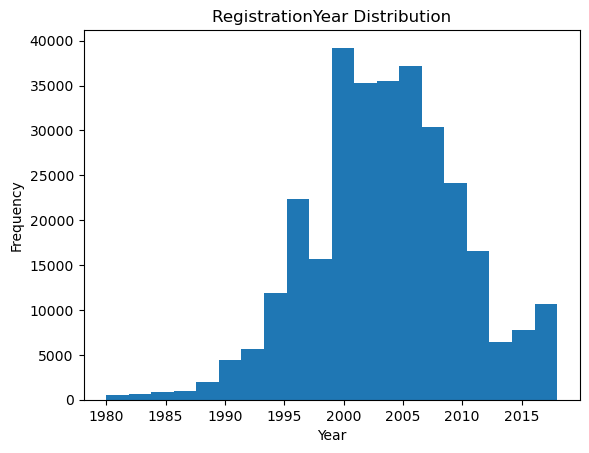

In [23]:
# Plotting RegistrationYear Distribution
plt.hist(car_data['RegistrationYear'], bins=20)
plt.title('RegistrationYear Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')

The problem with the RegistrationYear seems to be resolved. Looks like the majority of the cars were registered between 1995 and 2013.

Text(0, 0.5, 'Frequency')

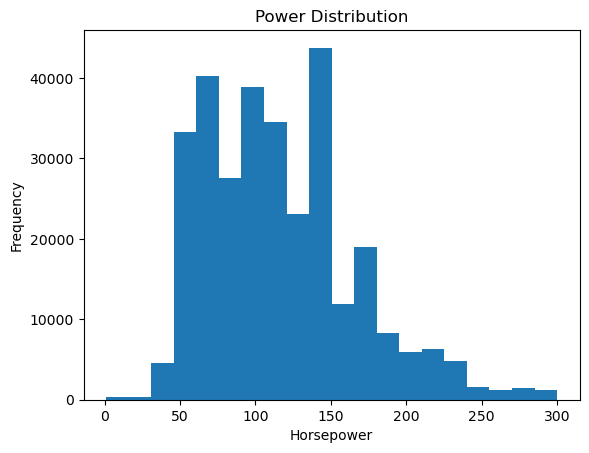

In [24]:
# Plotting Power Distribution
plt.hist(car_data['Power'], bins=20)
plt.title('Power Distribution')
plt.xlabel('Horsepower')
plt.ylabel('Frequency')

Looks like there are several spikes showing very common horsepower and we were able to get rid of the opsurd values that we had before.

Text(0, 0.5, 'Frequency')

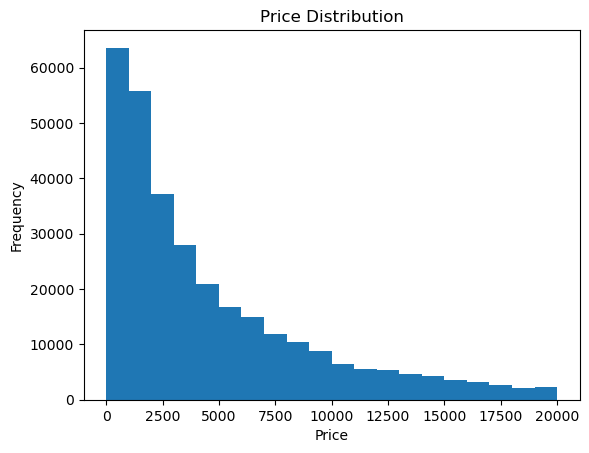

In [25]:
# Plotting Price Distribution
plt.hist(car_data['Price'], bins=20)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

We can see many cars being priced low and a steady decrease in quantity being priced higher.

Text(0, 0.5, 'Frequency')

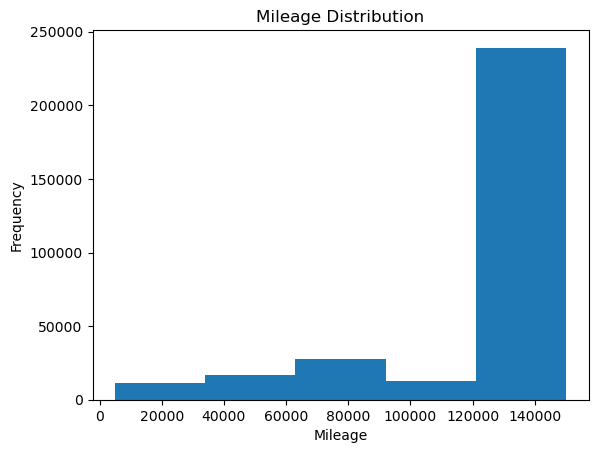

In [26]:
# Plotting Mileage Distribution
plt.hist(car_data['Mileage'], bins=5)
plt.title('Mileage Distribution')
plt.xlabel('Mileage')
plt.ylabel('Frequency')

Most cars are in the 140000 mile bin. We don't have a lot of variety in this column.

In [27]:
# Saving categorical features as a list
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Encoding categorical features using One Hot Encoding
encoded_data = pd.get_dummies(car_data, columns=categorical_features, drop_first=True)

In [28]:
# Checking head()
encoded_data.head()

,Price,RegistrationYear,Power,Mileage,NumberOfPictures,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
1,18300,2011,190,125000,0,66954,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,9800,2004,163,125000,0,90480,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1500,2001,75,150000,0,91074,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,3600,2008,69,90000,0,60437,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,650,1995,102,150000,0,33775,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [29]:
# Checking info
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308103 entries, 1 to 354368
Columns: 312 entries, Price to NotRepaired_yes
dtypes: bool(306), int64(6)
memory usage: 106.4 MB


After using One Hot Encoding I'm left with 312 columns but everything appears to have worked correctly.

## Model training

Now I will train a Linear Regression, Decision Tree Regressor, Random Forest Regressor and Light GBM Regressor model. I will also tune hyperparameters for each model in order to get the best predictions. I will evaluate the predictions using RMSE (Root Mean Squared Error) and I will also compare the time that it takes to train the models and make the predictions. I expect the Linear Regression model to perform the worst in terms of the RMSE so I will use it as a sanity check for the other models.

In [30]:
# Split the dataset into training, validation and testing sets
features = encoded_data.drop('Price', axis=1)
target = encoded_data['Price']

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42)

In [31]:
# Train Linear Regression
lr_model = LinearRegression()

# Training the model and calculating the fit time
start_lr_fit_time = time.time()
lr_model.fit(features_train, target_train)
lr_fit_time = time.time() - start_lr_fit_time

# Predicting and calculating the time to predict
start_lr_pred_time = time.time()
lr_pred = lr_model.predict(features_valid)
lr_pred_time = time.time() - start_lr_pred_time

# Finding the RMSE of the predictions
lr_rmse = mean_squared_error(target_valid, lr_pred, squared=False)

print(f'Linear Regression RMSE: {lr_rmse:.2f}, Fit time: {lr_fit_time:.2f} seconds, Predict time: {lr_pred_time:.2f} seconds')

Linear Regression RMSE: 2449.05, Fit time: 6.48 seconds, Predict time: 0.32 seconds


In [32]:
# Train Decision Tree and tune hyperparameters

# Save empty variables
best_dt_rmse = float('inf')
best_depth = 0
dt_fit_time = 0
dt_pred_time = 0

# For loop to find best hyperparameters
for depth in range(1, 21):
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Training the model and calculating the fit time
    start_fit_time = time.time()
    dt_model.fit(features_train, target_train)
    fit_time = time.time() - start_fit_time
    
    # Predicting and calculating the time to predict
    start_pred_time = time.time()
    dt_pred = dt_model.predict(features_valid)
    pred_time = time.time() - start_pred_time
    
    # Finding the RMSE of the predictions
    dt_rmse = mean_squared_error(target_valid, dt_pred, squared=False)
    
    # If statement to save info from the best performing models to variables saved earlier
    if dt_rmse < best_dt_rmse and dt_rmse > 0:
        best_dt_rmse = dt_rmse
        best_depth = depth
        dt_fit_time = fit_time
        dt_pred_time = pred_time
        
print(f'Best Decision Tree Depth: {best_depth}, RMSE: {best_dt_rmse:.2f}, Fit time: {dt_fit_time:.2f} seconds, Predict time: {dt_pred_time:.2f} seconds')

Best Decision Tree Depth: 14, RMSE: 1907.30, Fit time: 6.56 seconds, Predict time: 0.11 seconds


In [33]:
# Train Random Forest and tune hyperparameters

# Save empty variables
best_rf_rmse = float('inf')
best_rf_est = 0
rf_fit_time = 0
rf_pred_time = 0

# For loop to find best hyperparameters
for est in range(1, 26):
    rf_model = RandomForestRegressor(n_estimators=est, random_state=42)
    
    # Training the model and calculating the fit time
    start_fit_time = time.time()
    rf_model.fit(features_train, target_train)
    fit_time = time.time() - start_fit_time
    
    # Predicting and calculating the time to predict
    start_pred_time = time.time()
    rf_pred = rf_model.predict(features_valid)
    pred_time = time.time() - start_pred_time
    
    # Finding the RMSE of the predictions
    rf_rmse = mean_squared_error(target_valid, rf_pred, squared=False)
    
    # If statement to save info from the best performing models to variables saved earlier
    if rf_rmse < best_rf_rmse and rf_rmse > 0:
        best_rf_rmse = rf_rmse
        best_rf_est = est
        rf_fit_time = fit_time
        rf_pred_time = pred_time
        
print(f'Best number of Random Forest Estimators: {best_rf_est}, RMSE: {best_rf_rmse:.2f}, Fit time: {rf_fit_time:.2f} seconds, Predict time: {rf_pred_time:.2f} seconds')

Best number of Random Forest Estimators: 25, RMSE: 1637.48, Fit time: 192.75 seconds, Predict time: 1.58 seconds


In [34]:
# Train LightGBM Regressor and tune hyperparameters

# Save empty variables
best_lgb_rmse = float('inf')
best_lgb_est = 0
lgb_fit_time = 0
lgb_pred_time = 0

# For loop to find best hyperparameters
for est in range(1, 26):
    lgb_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=est, random_state=42, verbose=-1)
    
    # Training the model and calculating the fit time
    start_fit_time = time.time()
    lgb_model.fit(features_train, target_train)
    fit_time = time.time() - start_fit_time
    
    # Predicting and calculating the time to predict
    start_pred_time = time.time()
    lgb_pred = lgb_model.predict(features_valid)
    pred_time = time.time() - start_pred_time
    
    # Finding the RMSE of the predictions
    lgb_rmse = mean_squared_error(target_valid, lgb_pred, squared=False)
    
    # If statement to save info from the best performing models to variables saved earlier
    if lgb_rmse < best_lgb_rmse and lgb_rmse > 0:
        best_lgb_rmse = lgb_rmse
        best_lgb_est = est
        lgb_fit_time = fit_time
        lgb_pred_time = pred_time
        
print(f'Best number of Light GBM Estimators: {best_lgb_est}, RMSE: {best_lgb_rmse:.2f}, Fit time: {lgb_fit_time:.2f} seconds, Predict time: {lgb_pred_time:.2f} seconds')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 184861, number of used features: 289
[LightGBM] [Info] Start training from score 4632.139326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 184861, number of used features: 289
[LightGBM] [Info] Start training from score 4632.139326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 184861, number of used features: 289
[LightGBM] [Info] Start training from score 4632.139326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 184861, number of used features: 289
[LightGBM] [Info] Start training from score 4632.139326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

## Model Testing

In [35]:
# Testing Linear Regression model

# Predicting and calculating the time to predict
final_start_lr_pred_time = time.time()
final_lr_pred = lr_model.predict(features_test)
final_lr_pred_time = time.time() - final_start_lr_pred_time

# Finding the RMSE of the predictions
final_lr_rmse = mean_squared_error(target_test, final_lr_pred, squared=False)

print(f'Linear Regression RMSE: {final_lr_rmse:.2f}, Predict time: {final_lr_pred_time:.2f} seconds')

Linear Regression RMSE: 2466.77, Predict time: 0.33 seconds


In [36]:
# Testing Decision Tree model
final_dt_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
    
# Training the model and calculating the fit time
final_dt_start_fit_time = time.time()
final_dt_model.fit(features_train, target_train)
final_dt_fit_time = time.time() - final_dt_start_fit_time
    
# Predicting and calculating the time to predict
final_dt_start_pred_time = time.time()
final_dt_pred = final_dt_model.predict(features_test)
final_dt_pred_time = time.time() - final_dt_start_pred_time
    
# Finding the RMSE of the predictions
final_dt_rmse = mean_squared_error(target_test, final_dt_pred, squared=False)
        
print(f'Best Decision Tree Depth: {best_depth}, RMSE: {final_dt_rmse:.2f}, Fit time: {final_dt_fit_time:.2f} seconds, Predict time: {final_dt_pred_time:.2f} seconds')

Best Decision Tree Depth: 14, RMSE: 1929.20, Fit time: 6.74 seconds, Predict time: 0.11 seconds


In [37]:
# Testing Random Forest model
final_rf_model = RandomForestRegressor(n_estimators=best_rf_est, random_state=42)

# Training the model and calculating the fit time
final_start_rf_fit_time = time.time()
final_rf_model.fit(features_train, target_train)
final_rf_fit_time = time.time() - final_start_rf_fit_time

# Predicting and calculating the time to predict
final_start_rf_pred_time = time.time()
final_rf_pred = final_rf_model.predict(features_test)
final_rf_pred_time = time.time() - final_start_rf_pred_time

# Finding the RMSE of the predictions
final_rf_rmse = mean_squared_error(target_test, final_rf_pred, squared=False)
        
print(f'Final Random Forest RMSE: {final_rf_rmse:.2f}, Fit time: {final_rf_fit_time:.2f} seconds, Predict time: {final_rf_pred_time:.2f} seconds')

Final Random Forest RMSE: 1641.11, Fit time: 195.59 seconds, Predict time: 1.59 seconds


In [38]:
# Testing LGB model
final_lgb_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=best_lgb_est, random_state=42)

# Training the model and calculating the fit time
final_start_lgb_fit_time = time.time()
final_lgb_model.fit(features_train, target_train)
final_fit_time = time.time() - final_start_lgb_fit_time

# Predicting and calculating the time to predict
final_start_lgb_pred_time = time.time()
final_lgb_pred = final_lgb_model.predict(features_test)
final_pred_time = time.time() - final_start_lgb_pred_time

# Finding the RMSE of the predictions
final_lgb_rmse = mean_squared_error(target_test, final_lgb_pred, squared=False)
        
print(f'Final Light GBM RMSE: {final_lgb_rmse:.2f}, Fit time: {final_fit_time:.2f} seconds, Predict time: {final_pred_time:.2f} seconds')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 184861, number of used features: 289
[LightGBM] [Info] Start training from score 4632.139326
Final Light GBM RMSE: 2432.90, Fit time: 2.34 seconds, Predict time: 0.23 seconds


## Model analysis

All models did indeed perform better than the Linear Regression model. The Random Forest model had the lowest RMSE score. However, it was considerably slower than the other models, taking more than 3 minutes to fit the data. The fastest fit time was under 3 seconds from the Light GBM Regressor, however the RMSE score was not much better than the Linear Regression model. Overall the best performing model seems to be the Decision Tree. The Decision Tree RMSE score was not the lowest but it was significantly better than the Random Forest model and the Light GBM model. It's fit time was 6.74 seconds, beating the the Random Forest model by more than 3 minutes. It's prediction time was also the lowest of all the other models, coming in at 0.11 seconds.

    Linear Regression:
        RMSE: 2466.77
        Fit time: 6.48 seconds
        Prediction time: 0.33 seconds
    
    Decision Tree:
        Depth: 14
        RMSE: 1929.20
        Fit time: 6.74 seconds
        Predict time: 0.11 seconds

    Random Forest:
        Estimators: 25
        RMSE: 1641.11
        Fit time: 195.59 seconds
        Predict time: 1.59 seconds

    Light GBM:
        Estimators: 25
        RMSE: 2432.90
        Fit time: 2.34 seconds
        Predict time: 0.23 seconds

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed